In [2]:
# import libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.cross_decomposition import PLSRegression
import plotly.express as px
import plotly.graph_objects as go
!pip install bioinfokit
from bioinfokit.visuz import cluster

In [3]:
# import non imputed whole dataset

df = pd.read_excel(r"/content/drive/MyDrive/Fallers_prediction/mixed_non_imputed_dataset.xlsx",index_col=0)

# If year falls greater than 0 set to 1
df["Year Fall"] = df["Year Fall"].replace([2,3,4,5,6,7,8,9,10],1)

# Drop 3 columns
df.drop(['yr almost','6 Months Fall','Date of Evaluation'],axis=1,inplace=True)

# Replace n/a with np.nan
df.replace(r'^n',np.nan,regex=True,inplace=True)

# Drop rows containing N/As
df.dropna(inplace=True)

# Set the whole features except Year Fall as X and Year Fall as target
y = df["Year Fall"].values
X = df.drop(['Year Fall'],axis=1).values
X_scaled = MinMaxScaler().fit_transform(X)
column_names = df.drop(['Year Fall'],axis=1).columns
print(column_names)
print(df['Year Fall'].value_counts())

Index(['GCS (Neurotrax)', 'EFI (Exe. Func. Index)', 'Gender(1-female, 0-male)',
       'Age', 'GDS', 'ABC Tot %', 'SF-36', 'PASE', 'MMSE', 'MoCa', 'FAB',
       'TMTa', 'TMTb', 'TUG', 'FSST', 'BERG', 'DGI', 'DGI stairs',
       'base(velocity)', 's3(velocity)', 'feet close eyes open',
       'feet close eyes closed', 'tandem_eyes_open', 'tandem_eyes_closed',
       'sampen_ap', 'sampen_ml', 'sampen_v', 'dom_freq_ap', 'dom_freq_ampl_ap',
       'dom_freq_width_ap', 'dom_freq_slope_ap', 'dom_freq_ml',
       'dom_freq_ampl_ml', 'dom_freq_width_ml', 'dom_freq_slope_ml',
       'dom_freq_v', 'dom_freq_ampl_v', 'dom_freq_width_v',
       'dom_freq_slope_v'],
      dtype='object')
1.0    27
0.0    24
Name: Year Fall, dtype: int64


In [4]:
'''VIF'''

# detect multicollinearity with variance inflation factor

df_vif = pd.DataFrame()
df_vif["Feature"] = column_names
df_vif["VIF"] = [variance_inflation_factor(X,i) for i in range(X.shape[1])]
print(df_vif.sort_values(by=['VIF']))



                     Feature          VIF
35                dom_freq_v     9.272099
23        tandem_eyes_closed    11.580362
2   Gender(1-female, 0-male)    11.916257
22          tandem_eyes_open    15.302520
31               dom_freq_ml    19.928516
21    feet close eyes closed    26.433183
4                        GDS    26.633223
7                       PASE    27.328105
27               dom_freq_ap    50.993602
20      feet close eyes open    79.067760
33         dom_freq_width_ml    89.638695
17                DGI stairs   120.094004
11                      TMTa   124.095819
10                       FAB   131.235668
12                      TMTb   144.013706
25                 sampen_ml   187.730599
14                      FSST   196.481976
19              s3(velocity)   206.765816
38          dom_freq_slope_v   208.363081
36           dom_freq_ampl_v   215.087502
6                      SF-36   216.390458
5                  ABC Tot %   228.213991
30         dom_freq_slope_ap   277

In [5]:
'''Partial Least Squares VIP scores'''

# partial least squares vip scores (more suitable for variable selection when multicollinearity is present)
# we defined good predictors when vip score > 1, as it's suggested by the paper from Il-Gyo Chong & Chi-Hyuck Jun 2005
# function calculate_vips was taken from Keiron Teilo O'Shea, found on a researchgate forum
def calculate_vips(model):
    t = pls.x_scores_
    w = pls.x_weights_
    q = pls.y_loadings_
    p, h = w.shape
    vips = np.zeros((p,))
    s = np.diag(np.matmul(np.matmul(np.matmul(t.T,t),q.T), q)).reshape(h, -1)
    total_s = np.sum(s)
    for i in range(p):
        weight = np.array([ (w[i,j] / np.linalg.norm(w[:,j]))**2 for j in range(h) ])
        vips[i] = np.sqrt(p*(np.matmul(s.T, weight))/total_s)
    return vips

pls = PLSRegression()
pls.fit_transform(X_scaled,y)
vip = calculate_vips(pls)
df_pls_vip = pd.DataFrame()
df_pls_vip["Feature"] = column_names
df_pls_vip["VIP SCORE"] = vip
df_pls_vip["Beta SCORE"] = np.abs(pls.coef_)
print(df_pls_vip.sort_values(by = ["VIP SCORE"],ascending = False))

                     Feature  VIP SCORE  Beta SCORE
6                      SF-36   1.872609    0.104134
22          tandem_eyes_open   1.545857    0.088432
37          dom_freq_width_v   1.525763    0.085134
4                        GDS   1.474771    0.082650
20      feet close eyes open   1.465037    0.079031
18            base(velocity)   1.346753    0.043134
16                       DGI   1.305634    0.009184
13                       TUG   1.238893    0.006268
14                      FSST   1.155189    0.009930
19              s3(velocity)   1.155141    0.025381
5                  ABC Tot %   1.144234    0.046587
15                      BERG   1.142733    0.025518
17                DGI stairs   1.130863    0.011412
7                       PASE   1.127534    0.045042
26                  sampen_v   1.121177    0.064046
2   Gender(1-female, 0-male)   1.109171    0.049283
12                      TMTb   1.096513    0.033864
35                dom_freq_v   0.994801    0.055449
36          

In [6]:
'''Principal Component Analysis'''

pca = PCA(n_components=3)
pca.fit(X_scaled)
pca_features = pca.transform(X_scaled)
pca_df = pd.DataFrame(pca_features,columns=['PCA1','PCA2','PCA3'])
target_var = []
for i in y:
  if i == 0:
    target_var.append('Non Faller')
  else:
    target_var.append('Faller')
df_target_var = pd.DataFrame(target_var,columns=['Group'])
df_pca = pd.concat([pca_df,df_target_var],axis=1)
loading_scores = pca.components_
df_loadings = pd.DataFrame(loading_scores.T,columns=['PCA1','PCA2','PCA3'],index=column_names)
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(np.round(explained_variance,decimals=2))
df_explained_var = pd.concat([pd.DataFrame(['PCA1','PCA2','PCA3'],columns=['PC']),
                              pd.DataFrame(explained_variance,columns=['Explained Variance']),
                              pd.DataFrame(cumulative_variance,columns=['Cumulative Variance'])],axis=1)
print(df_loadings)

                              PCA1      PCA2      PCA3
GCS (Neurotrax)          -0.161642 -0.022524  0.070732
EFI (Exe. Func. Index)   -0.129262  0.004559  0.063092
Gender(1-female, 0-male)  0.396728 -0.694991  0.477369
Age                       0.061430  0.044587  0.026601
GDS                       0.089510  0.030292 -0.209431
ABC Tot %                -0.220684 -0.123362  0.201055
SF-36                    -0.206236 -0.042013  0.150431
PASE                     -0.117486 -0.060625 -0.027155
MMSE                     -0.082406 -0.261763  0.088863
MoCa                     -0.021286 -0.168380 -0.064677
FAB                      -0.057354 -0.140278  0.013409
TMTa                      0.101286  0.137095  0.080419
TMTb                      0.168295  0.096552  0.001867
TUG                       0.199302  0.050499 -0.065918
FSST                      0.191189  0.055486 -0.037972
BERG                     -0.248253 -0.134048  0.018833
DGI                      -0.290271 -0.042087  0.074363
DGI stairs

In [7]:
# Scree Plot

fig = go.Figure()

fig.add_trace(go.Bar(x=df_explained_var['PC'],y=df_explained_var['Explained Variance'],marker=dict(color='RoyalBlue')))
fig.add_trace(go.Scatter(x=df_explained_var['PC'],y=df_explained_var['Cumulative Variance'],marker=dict(size=12,color='DarkViolet')))
fig.show()

In [8]:
# PCA components 3d plot

fig = px.scatter_3d(df_pca,x='PCA1',y='PCA2',z='PCA3',color=df_pca['Group'],opacity=0.5)
fig.update_layout(template='plotly_dark')

loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

for i, feature in enumerate(column_names):
    fig.add_shape(
        type='line',
        x0=0, y0=0,
        x1=loadings[i, 0],
        y1=loadings[i, 1]
    )
    fig.add_annotation(
        x=loadings[i, 0],
        y=loadings[i, 1],
        ax=0, ay=0,
        xanchor="center",
        yanchor="bottom",
        text=feature,
    )
fig.show()

In [9]:
# Loading scores plot

loading_scores_labels = df_loadings.index
fig = px.scatter_3d(df_loadings,x='PCA1',y='PCA2',z='PCA3',text=loading_scores_labels)
fig.show()

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


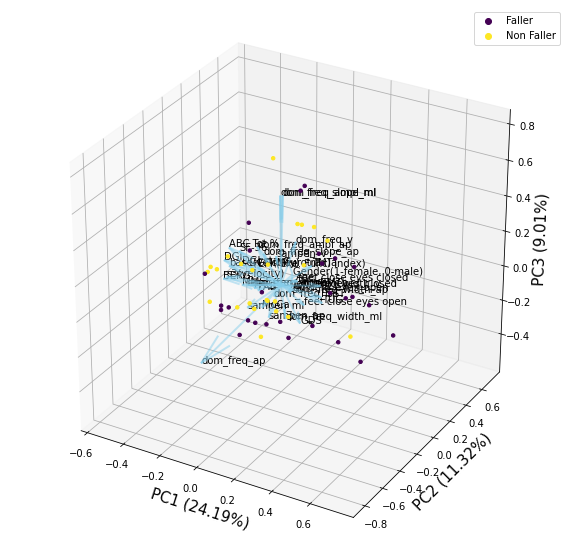

In [10]:
'''PCA Biplot'''

cluster.biplot(cscore=pca_features,loadings=loading_scores,labels=loading_scores_labels,
                var1=np.round(df_explained_var['Explained Variance'][0]*100,2),
               var2=np.round(df_explained_var['Explained Variance'][1]*100,2),
               var3=np.round(df_explained_var['Explained Variance'][2]*100,2),
               show=True,colorlist=target_var,dim=(10,10),dotsize=12,arrowlinewidth=2,axlabelfontsize=15,
               valphaarrow=0.5)

### **We observe that the 3 principal components explain a small percentage of variance in the dataset. Thus we have lost a lot information and cannot have valid insights**

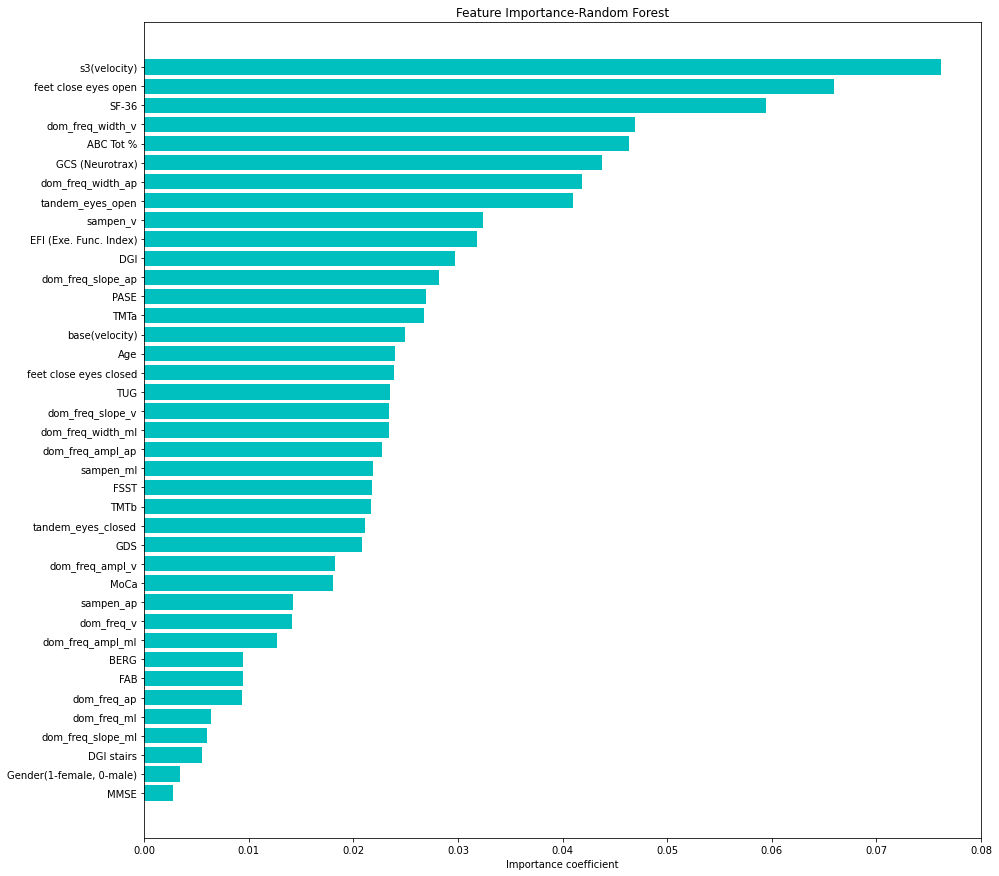

In [11]:
'''Random Forest Classifier'''

# use random forest to find feature importance coefficients
rand_for = RandomForestClassifier()
rand_for.fit(X,y)
feature_importance = rand_for.feature_importances_
indices = np.argsort(feature_importance)

# plot random forest feature importance coefficients
plt.figure(figsize=[15,15])
plt.barh(range(len(indices)),feature_importance[indices],color ="c",align="center")
plt.yticks(range(len(indices)),[column_names[i] for i in indices])
plt.title("Feature Importance-Random Forest")
plt.xlabel("Importance coefficient")
plt.show()

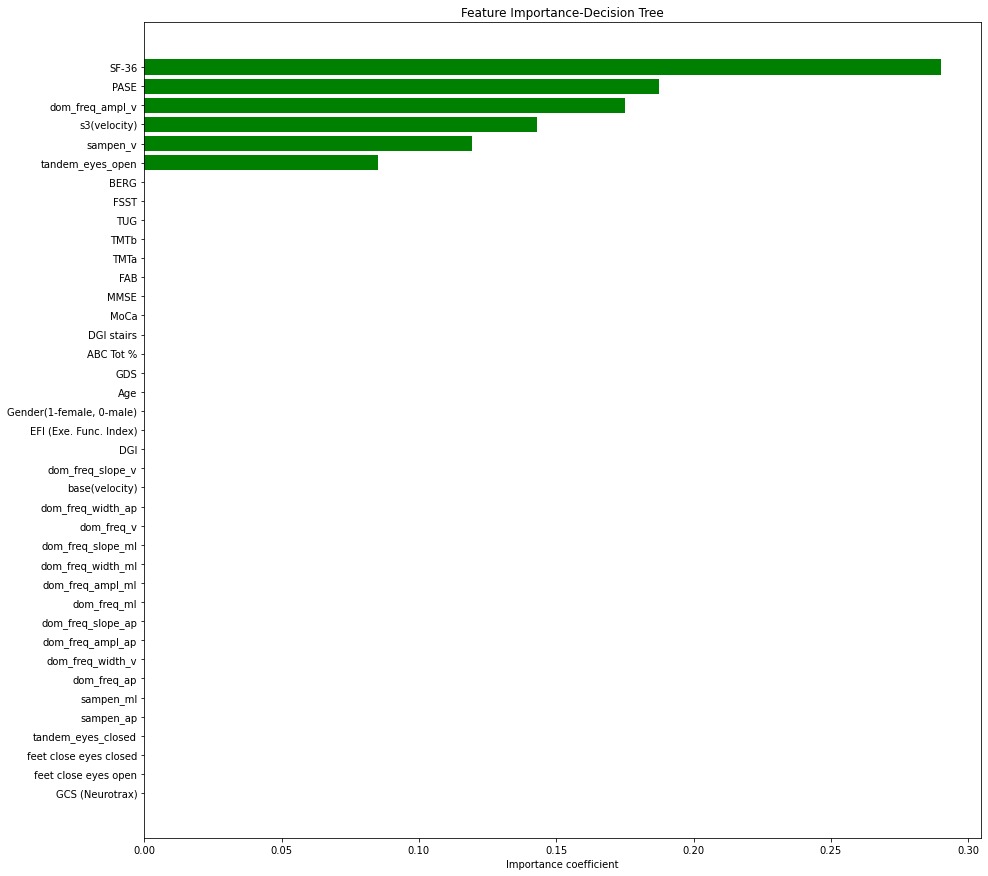

In [12]:
'''Decision Tree'''

# use decision tree to find feature importance coefficients
dec_tree = DecisionTreeClassifier()
dec_tree.fit(X,y)
best_features = dec_tree.feature_importances_
index = np.argsort(best_features)

# plot decision tree feature importance coefficients
plt.figure(figsize=[15,15])
plt.barh(range(len(index)),best_features[index],color ="g",align="center")
plt.yticks(range(len(index)),[column_names[i] for i in index])
plt.title("Feature Importance-Decision Tree")
plt.xlabel("Importance coefficient")
plt.show()

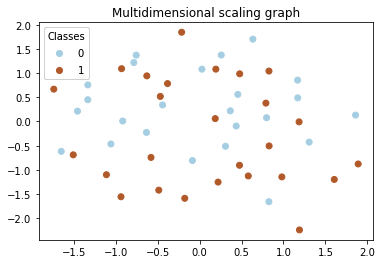

In [14]:
from sklearn.manifold import MDS

mds = MDS(n_components=2,random_state=0,metric=True)
mds_coordinates = mds.fit_transform(X_scaled)

mds_df = pd.DataFrame(mds_coordinates,columns=["x","y"],index=df.index)
mds_df = pd.concat([mds_df,pd.Series(df['Year Fall'])],axis=1)

fig, ax = plt.subplots()

scatter = ax.scatter(mds_df.x, mds_df.y,c=mds_df['Year Fall'],cmap=plt.cm.Paired)
plt.title('Multidimensional scaling graph')

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(),
                    loc="upper left", title="Classes")
ax.add_artist(legend1)

#for sample in mds_df.index:
    #plt.annotate(sample,(mds_df.x.loc[sample],mds_df.y.loc[sample]))
plt.show()